## Polynomial regression with gradient descent

Let $z \in \mathbb{R}$ and consider the polynomial
\begin{equation}
    p(z) = \frac{z^4}{100} - \frac{z^3}{10} + 5z^2 -z + 1  = {\sum_{ k = 0}^4 z^k w_k}
\end{equation}
where ${w} = [w_0, w_1, w_2, w_3, w_4]^T = [1, -1, 5, -0.1, \frac{1}{100}]^T$. This polynomial can also be expressed as the dot product of two vectors, namely
$$p(z) = {x}{w}^T \quad {x} = [1, z, z^2, z^3, z^4]$$

Consider an independent and identically distributed (i.i.d.) dataset $\mathcal{D} = \{(z_i, y_i)\}_{i = 1}^N$, where $y_i = p(z_i) + \varepsilon_i$, and each $\varepsilon_i$ is drawn from a normal distribution with mean zero and standard deviation $\sigma$.

Now, assuming that the vector ${w}$ is unknown, linear regression could estimate it using the dot-product form presented in the previous Equation. To achieve this, we can move to another dataset
$$\mathcal{D}' := \{({x}_i, y_i)\}_{i = 1}^N \qquad {x}^i =  [1, z_i, z_i^2, z_i^3, z_i^4]$$

The task of this assignment is to perform polynomial regression using gradient descent with PyTorch.

In [127]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [128]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

### Task 1
Define a function `plot_polynomial(coeffs, z_range, color='b')`, where `coeffs` is a `np.array` containing $[w_0, w_1, w_2, w_3, w_4]^T$,  `z_range` is the interval $[z_{\text{min}}, z_{\text{max}}]$ of the $z$ variable; `color` represent a color. Use the function to plot the polynomial in the range $[-4, 4]$. Report the plot. In coding this function, you can use `numpy`.

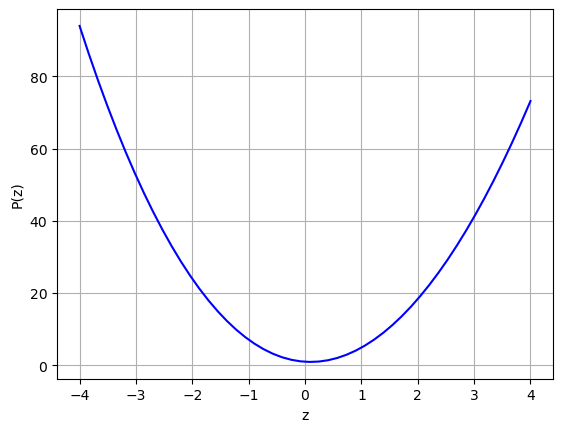

In [130]:
def plot_polynomial(coeffs, z_range, color='b'):
    z = np.linspace(z_range[0], z_range[1], 50)  #generate 50 points equi-distanced from each other  in the range zmin,zmax
    y = np.polyval(coeffs[::-1], z)  #compute polynomial  values, inverting the order of coefficients (we want to have w4,w3,w2,w1,w0). It is a raw vector
    
    plt.plot(z, y, color=color)   
    plt.xlabel('z')
    plt.ylabel('P(z)')
    plt.grid(True)
    plt.show()

coeffs = np.array([1, -1, 5, -0.1, 0.01])  # w0, w1, w2, w3, w4
plot_polynomial(coeffs, [-4, 4], color='b')
    

### Task 2 
Write a function `create_dataset(coeffs, z_range, sample_size, sigma, seed=42)` that generates the dataset $\mathcal{D'}$.  where `coeffs` is a `np.array` containing $[w_0, w_1, w_2, w_3, w_4]^T$,  `z_range` is the interval $[z_{\text{min}}, z_{\text{max}}]$ of the $z$ variable; `sample_size` is the dimension of the sample; `sigma` is the standard deviation of the normal distrbution from which $\varepsilon_i$ are sampled; `seed` is the seed for the random procedure. Your function must return two `torch.tensor` with the noisy dataset.

In [131]:
def create_dataset(coeffs, z_range, sample_size, sigma, seed=42):
    z = np.linspace(z_range[0], z_range[1], sample_size)   #create random and independent values
    x = np.column_stack([z**i for i in range(5)])   #create a list of 5 array(so a Matrix), for each power of z. 
    clean_pol = x@coeffs            #compute the polynomial  function without noise (the noise must be add manually)
    noise = np.random.normal(loc=0, scale = sigma, size=sample_size) #generate noise with random values taken by standard deviation with sample size dimension 
    noisy_pol = clean_pol + noise  #adding noise to the function 
    x_tensor=torch.from_numpy(x).float()       #float works better in pythorch with models 
    y_tensor= torch.from_numpy(noisy_pol).float()
    return x_tensor, y_tensor 

### Task 4 

Use the code of the previous point to generate data with the following parameters
- Each $z_i$ should be in the interval $[-2, 2]$
- $\sigma = 0.5$
- Use a sample size of 500 for training data and a seed of 0
- Use a sample size of 500 for evaluation data and a seed of 1

In [132]:
# TODO
x_train, y_train = create_dataset(coeffs, [-2, 2], 500, 0.5, 0)
x_e, y_e = create_dataset(coeffs, [-2, 2], 500, 0.5, 1)

print ("training x: " , x_train, "\n training y:", y_train)
print ("\n evaluation x: ",  x_e, "\n evaluation y:", y_e)


training x:  tensor([[ 1.0000, -2.0000,  4.0000, -8.0000, 16.0000],
        [ 1.0000, -1.9920,  3.9680, -7.9042, 15.7450],
        [ 1.0000, -1.9840,  3.9361, -7.8092, 15.4931],
        ...,
        [ 1.0000,  1.9840,  3.9361,  7.8092, 15.4931],
        [ 1.0000,  1.9920,  3.9680,  7.9042, 15.7450],
        [ 1.0000,  2.0000,  4.0000,  8.0000, 16.0000]]) 
 training y: tensor([23.9892, 23.6041, 23.4780, 23.8893, 23.1423, 22.5482, 22.7075, 22.7084,
        22.6708, 22.7021, 21.5851, 22.3240, 21.4534, 21.8754, 21.3905, 22.3465,
        20.5349, 21.2029, 21.1853, 20.4841, 20.9741, 20.3400, 20.0577, 19.9585,
        19.8044, 19.3637, 19.7408, 19.3684, 19.1600, 18.9757, 18.5245, 19.2694,
        18.7806, 18.6784, 18.5828, 17.6549, 18.0238, 18.7171, 17.7236, 17.6676,
        17.2686, 16.9125, 16.9830, 16.9036, 17.1536, 16.6465, 16.0251, 16.8289,
        16.6180, 14.9634, 15.5408, 15.4603, 15.8098, 15.7238, 15.6295, 15.6213,
        14.8840, 15.3919, 15.0739, 14.9409, 14.7315, 14.3801, 14.0506

### Task 5 
Define a function `visualize_data(X, y, coeffs, z_range, title="")` that plots the polynomial $p(z)$ and the generated data, (train and validation), where `X, y` are as returned from the function `create_dataset`, `coeffs` are the coefficient of the polynomial, `z_range` is the interval $[z_{\text{min}}, z_{\text{max}}]$  of the $z$ variable and `title` may be helpful to distinguish between the training and the validation plots. More specifically, provide two plots containing both the true polynomial. In one, add a scatter plot with the training data, and in the other, a scatter plot with the validation data. Use the function to visualize the data.  At this point, you should have noticed that, depending on the circumstances, it is advantageous to store the polynomial coefficients either from the degree 0 term to the degree $n$ term, or vice versa.

In [133]:
def visualize_data(X, y, coeffs, z_range, title=""):
#define function    
    z_linspace = np.linspace(z_range[0], z_range[1], 50)
    y_poly = np.polyval(coeffs[::-1], z_linspace)
    plt.plot(z_linspace, y_poly, color='blue', label="Polynomial")

#noisy data   
    plt.scatter(X[:,1], y, color='orange', label="Data", alpha= 0.5)  #the first coloumn of matrix X corresponding to the real data, with coefficients  z^1

#plotting 
    plt.xlabel("z")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

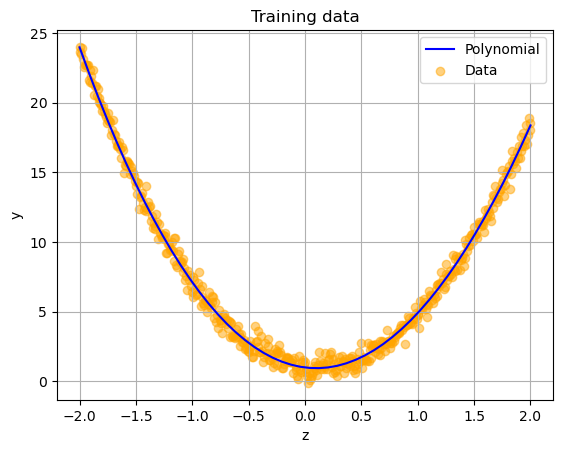

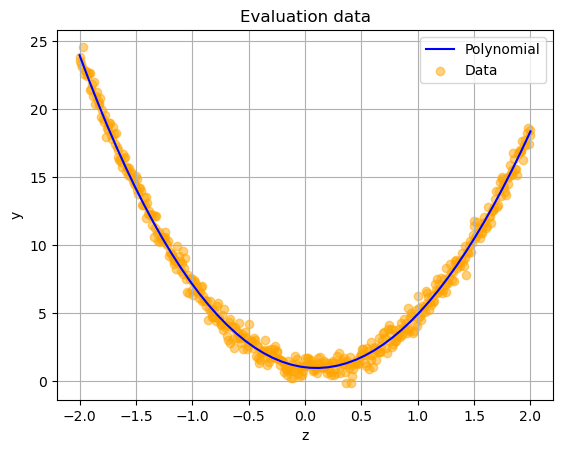

In [134]:
# TODO
visualize_data(x_train, y_train, coeffs, [-2,2], "Training data")
visualize_data(x_e, y_e, coeffs, [-2,2], "Evaluation data")

### Task 6 
Perform polynomial regression on $\mathcal{D}$ using linear regression on $\mathcal{D'}$. You will be asked to motivate
- Which learning rate do you use, and why;
- What happens if the learning rate is too small? What happens if the learning rate is too high, and why?
- If `bias` should be set as `True` or `False` in `torch.nn.Linear` and why. 
- How many steps did you use, and why did you retain that  they were enough

You should use the data you generated at Task 4. 

In [ ]:
y_train = y_train.unsqueeze(1)
y_e = y_e.unsqueeze(1)
torch.manual_seed = 0.7                     #define the seed 
model = nn.Linear(in_features=5, out_features=1, bias=False)  #define linear model 
criterion = nn.MSELoss()                       #define criterion: Mean Squared Error 
optimizer = optim.SGD(model.parameters(), lr=0.025)          #define optimezer stochastic gradient descent 

num_steps=5000          #define number of steps 
train_losses = []       
val_losses = []

for step in range(num_steps):
    model.train()                           #activation training mode 
    optimizer.zero_grad()                  # reset gradients 
    y_pred = model(x_train)                # output prediction 
    loss = criterion(y_pred, y_train)      # compute loss function 
    loss.backward()                        # backward pass
    optimizer.step()                       # update weights by stochastic gradient descent 

    train_losses.append(loss.item())       
    model.eval()                           #activation evaluation mode
    with torch.no_grad():
        y_val_pred = model(x_e)             
        val_loss = criterion(y_val_pred, y_e)
        val_losses.append(val_loss.item())
   
    if step == 0:
        weight_history = model.weight.detach().numpy().copy()
    
    else:
        weight_history = np.vstack((weight_history, model.weight.detach().numpy().copy()))
   

    # monitoring train loss and evaluation loss each 500 steps 
    if step % 500 == 0:
        print(f"Step {step}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

learned_norm = model.weight.detach().numpy().flatten()


Step 0, Train Loss: 84.4057, Val Loss: 35.0228
Step 500, Train Loss: 0.2502, Val Loss: 0.2974
Step 1000, Train Loss: 0.2368, Val Loss: 0.2771
Step 1500, Train Loss: 0.2367, Val Loss: 0.2762
Step 2000, Train Loss: 0.2367, Val Loss: 0.2761
Step 2500, Train Loss: 0.2367, Val Loss: 0.2761
Step 3000, Train Loss: 0.2367, Val Loss: 0.2761
Step 3500, Train Loss: 0.2367, Val Loss: 0.2761
Step 4000, Train Loss: 0.2367, Val Loss: 0.2761
Step 4500, Train Loss: 0.2367, Val Loss: 0.2761


### Task 7 
Plot the training and validation loss as functions of the iterations and report them in the same plot. If you use both steps and epochs, you can choose either of the two, as long as it is clear from the plot and the plot reports what we expect - namely, that the loss functions decrease.

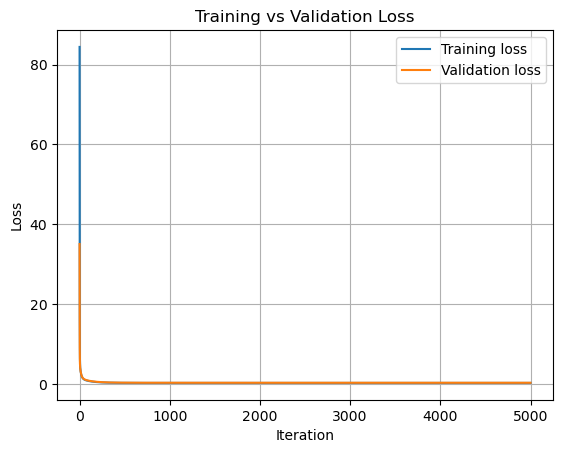

In [136]:
# TODO
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.yscale('log')   in case we want to evaluate with log scale 
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### Task 8 
Define a function `plot_polynomials(coeffs_list, z_range, color='b')`, where `coeffs_list` is a list containing `np.array`s of type $[w_0, w_1, w_2, w_3, w_4]^T$ of the polynomials you want to plot,  `z_range` is the interval $[z_{\text{min}}, z_{\text{max}}]$ of the $z$ variable; `colors` is a  list of colors, `legend` is a list of labels you want to put. Use the function to plot the polynomial in the range $[-4, 4]$. Report the plot. In coding this function, you can use `numpy`.

In [137]:
def plot_polynomials(coeffs_list, z_range, colors, legend, title="Polynomials Comparison"):
    z = np.linspace(z_range[0], z_range[1], 200)  #create a smooth range of z values 
    for coeffs, color, label in zip(coeffs_list, colors, legend):
        X_poly = np.column_stack([z**i for i in range(len(coeffs))])
        y = X_poly @ coeffs
        plt.plot(z, y, color=color, label=label, linewidth=2, alpha=0.5)
    plt.xlabel("z")
    plt.ylabel("p(z)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

True coeffs:    [ 1.   -1.    5.   -0.1   0.01]
Learned coeffs: [ 1.0228276  -1.0189209   4.9459577  -0.09869424  0.0240964 ]


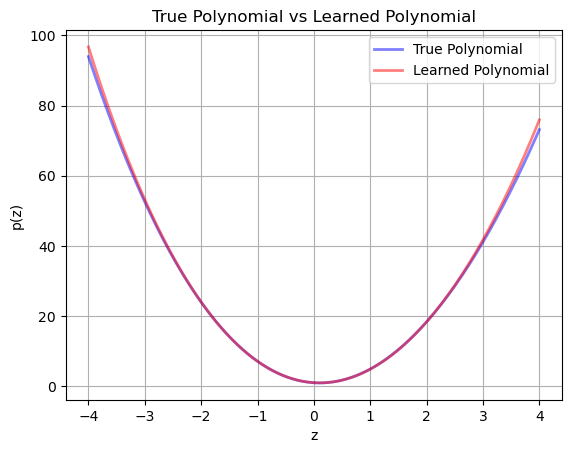

In [138]:
#get back coefficient from the model 
learned_coeffs = model.weight.detach().cpu().numpy().flatten() # [w0, w1, w2, w3, w4]
print("True coeffs:   ", coeffs)
print("Learned coeffs:", learned_coeffs)

# Original Polynomial 
true_coeffs = coeffs  # [1, -1, 5, -0.1, 1/100]


# Plot the original polynomial and learned polynomial 
plot_polynomials(
    coeffs_list=[true_coeffs, learned_coeffs],
    z_range=[-4, 4],
    colors=['blue', 'red'],
    legend=['True Polynomial', 'Learned Polynomial'],
    title="True Polynomial vs Learned Polynomial"
)

### Task 9 
Plot the value of the parameters at each iteration, as well as the true value. What we expect is a plot having on the $x$ axis the number of steps/epochs and on the $y$ axis the value of the parameters while they are learned. Then, in the same graph, plot a horizontal line with the true value.

In [139]:
#Plot the evolution of each learned weight over iterations, compared to the true coefficients.

def plot_parameter_evolution(weight_history, true_coeffs):

    num_steps = weight_history.shape[0]
    num_coeffs = weight_history.shape[1]

    plt.figure(figsize=(10, 6))

    # Plot the convergences graph each coefficient (w0, w1, w2, w3, w4)
    for i in range(num_coeffs):
        plt.plot(range(num_steps), weight_history[:, i], label=f"w{i} (learned)")
        plt.hlines(y=true_coeffs[i], xmin=0, xmax=num_steps-1,
                   colors='k', linestyles='--', label=f"w{i} true" if i == 0 else None)
        
    plt.xlabel("Training step")
    plt.ylabel("Weight value")
    plt.title("Evolution of learned coefficients vs true values")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    

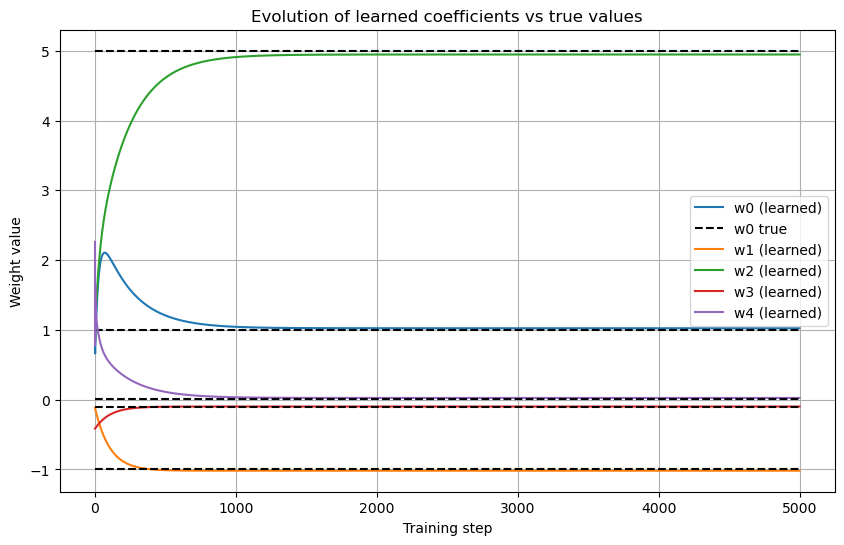

In [140]:
plot_parameter_evolution(weight_history, coeffs)